In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import neuraltda.topology2 as tp2
import neuraltda.stimulus_space as sc
import neuraltda.spectralAnalysis as sa
import pandas as pd
import h5py as h5
import pickle

import tqdm

import os
import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

# Class to define environments with holes
class TPEnv:
    
    def __init__(self, n_holes, hole_rad):
        self.xlim = [-1, 1]
        self.ylim = [-1, 1]
        self.holes = []
        self.hole_rad = hole_rad
        c = 0.75*(2*np.random.rand(2) - 1)
        for hole in range(n_holes):
            while self.hole_collide(c):
                c = 0.75*(2*np.random.rand(2) - 1)
            self.holes.append(c)
        #self.holes = 0.75*(2*np.random.rand(n_holes, 2) - 1) # keep centers in range -1, 1
        self.hole_rad = hole_rad # radius of holes
        
    def in_hole(self, x, y):
        '''
        Check to see if a point is in a hole
        '''
        for hole in self.holes:
            if np.linalg.norm(np.subtract([x, y], hole)) < self.hole_rad:
                return True
        return False
        
    def hole_collide(self, c):
        '''
        Check to see if a hole will collide with already existing holes 
        '''

        for h in self.holes:
            if np.sqrt((h[0] - c[0])**2 + (h[1] - c[1])**2) <= 2*self.hole_rad:
                return True
        return False
    
    
def generate_environments(N, h, numrepeats=1):
    envs = []
    for nholes in range(N):
        for r in range(numrepeats):
            envs.append(TPEnv(nholes, h))
    return envs

def convert_env_to_img(env,  NSQ):
    img = np.ones((NSQ, NSQ))
    X, Y = np.meshgrid(np.linspace(-1, 1, NSQ), np.linspace(-1, 1, NSQ))
    
    for hole in env.holes:
        hx = hole[0]
        hy = hole[1]
        diffx = X - hx*np.ones(np.shape(X))
        diffy = Y - hy*np.ones(np.shape(Y))
        dists = np.sqrt(np.power(diffx, 2) + np.power(diffy, 2))
        img[dists < env.hole_rad] = 0
        
    return img 

def compute_env_img_correlations(imgs):
    nsq, _ = np.shape(imgs[0])
    dat_mat = np.zeros((len(imgs), nsq*nsq))
    for ind,img in enumerate(imgs):
        dat_mat[ind, :] = img.flatten()
        
    cormat = np.corrcoef(dat_mat)
    return cormat
    

def generate_paths(space, n_steps, ntrials, dl):
    # pick a starting point
    final_pts = np.zeros((ntrials, n_steps, 2))
    for trial in range(ntrials):
        pts = []
        pt = (2*np.random.rand(1, 2) - 1)[0]
        while space.in_hole(pt[0], pt[1]):
            pt = (2*np.random.rand(1, 2) - 1)[0]
        #pts.append(pt)
        steps_to_go = n_steps
        while steps_to_go > 0:
            if steps_to_go % 10000 == 0:
                print("Steps to go: {}".format(steps_to_go))
            # pick a new point
            #theta = np.pi*np.random.rand(1)[0] - np.pi/2
            
            theta = 2*np.pi*np.random.rand(1)[0]
            dx = dl*np.cos(theta)
            dy = dl*np.sin(theta)

            if (abs(pt[0]+dx) < 1 and 
               abs(pt[1]+dy) < 1 and
                not space.in_hole(pt[0]+dx, pt[1]+dy)):
                
                steps_to_go -= 1

                pt[0] = pt[0] + dx
                pt[1] = pt[1] + dy
                pts.append(np.copy(pt))
        pts = np.vstack(pts)
        final_pts[trial, :, :] = pts
    return final_pts

def generate_place_fields_random(n_fields, rad):
    
    centers =2*np.random.rand(n_fields, 2) - 1
    return (centers, rad)

def generate_place_fields(n_fields, rad):
    
    nf = np.round(np.sqrt(n_fields))
    cx = np.linspace(-1, 1, nf)
    cy = np.linspace(-1, 1, nf)
    centers = np.array([np.array((x, y)) for x in cx for y in cy])
    rads = rad*np.ones(n_fields)
    return (centers, rads)

def generate_place_fields_perturbed_lattice(n_fields, rad, stddev=0.1):
    ''' generates place fields with centers normally perturbed around a lattice'''
    nf = np.round(np.sqrt(n_fields))
    cx = np.linspace(-1, 1, nf)
    cy = np.linspace(-1, 1, nf)
    cx = cx + stddev*np.random.randn(len(cx))
    cy = cy + stddev*np.random.randn(len(cy))
    centers = np.array([np.array((x, y)) for x in cx for y in cy])
    return (centers, rad)

def generate_place_fields_CI(n_fields, rad_range,exclusion_param):
    radii = (rad_range[1] - rad_range[0])*np.random.random_sample(n_fields) + rad_range[0]
    field_c = []
    for field in range(n_fields):
        #print('field = ', field)
        # pick a center in range -1, 1
        c = 2*np.random.rand(2) - 1
        if field == 0:
            field_c.append(c)
            continue
        added = False
        collision = False
        trie = 0
        maxtries = 100
        #print('field c', field_c)
        while trie < maxtries and added == False:
            #print('trie', trie)
            for cbar_ind, cbar in enumerate(field_c):
                #print('cbar', cbar)
                if np.linalg.norm(c-cbar) < exclusion_param*radii[cbar_ind]:
                    # already a field there, try again
                    #print('collision')
                    c = 2*np.random.rand(2) - 1
                    collision = True
                    break
            if collision:
                trie+=1
                collision = False
                continue
            else:
                field_c.append(c)
                added = True
        if not added:
            field_c.append(c)
    return (np.array(field_c), radii)
            
def generate_spikes_gaussian(paths, fields, max_rate, sigma):
    
    ncell, dim = fields.shape
    ntrial, nwin, _ = paths.shape
    
    spikes = np.zeros((ncell, nwin, ntrial))

    P1 = paths[:, :, np.newaxis, :]
    C1 = fields[np.newaxis, np.newaxis, :, :]

    P1 = np.tile(P1, [1, 1, ncell, 1])
    C1 = np.tile(C1, [ntrial, nwin, 1, 1])

    S = P1 - C1
    M = np.einsum('ijkl, ijkl->ijk', S, S)
    probs = max_rate*np.exp(-1*M / (2*sigma**2))
    spikes = 1*np.greater(probs, np.random.random(np.shape(probs)))
    return np.einsum('ijk->kji', spikes)

def generate_spikes(paths, fields, max_rate, rads):
    
    ncell, dim = fields.shape
    ntrial, nwin, _ = paths.shape
    
    spikes = np.zeros((ncell, nwin, ntrial))

    P1 = paths[:, :, np.newaxis, :]
    C1 = fields[np.newaxis, np.newaxis, :, :]

    P1 = np.tile(P1, [1, 1, ncell, 1])
    C1 = np.tile(C1, [ntrial, nwin, 1, 1])

    S = P1 - C1
    M = np.einsum('ijkl, ijkl->ijk', S, S)
    #SIGMA = sigma*np.ones(M.shape)
    #forgot square root
    M = np.sqrt(M)
    SIGMA = np.tile(rads[np.newaxis, np.newaxis, :], (ntrial, nwin, 1))
    # if distance is less than sigma, then p = max_rate
    probs = max_rate*np.less(M, SIGMA)
    spikes = 1*np.greater(probs, np.random.random(np.shape(probs)))
    return np.einsum('ijk->kji', spikes)

def spikes_to_dataframe(spikes, fs, nsecs):
    (ncells, nwin, ntrial) = spikes.shape
    spikes_frame = pd.DataFrame(columns=['cluster', 'time_samples', 'recording'])
    trials_frame = pd.DataFrame(columns=['stimulus', 'time_samples', 'stimulus_end'])
    for trial in range(ntrial):
        for cell in range(ncells):
            cellspikes = np.nonzero(spikes[cell, :, trial])[0] + trial*(nsecs+2)*fs
            celldict = {'cluster': len(cellspikes)*[cell], 'time_samples': cellspikes, 'recording': len(cellspikes)*[0]}
            cellframe = pd.DataFrame(celldict)
            spikes_frame = spikes_frame.append(cellframe, ignore_index=True)
        trial_frame = pd.DataFrame({'stimulus': 'joe', 'time_samples': trial*(nsecs+2)*fs, 'stimulus_end': (trial*(nsecs+2) + nsecs)*fs, 'recording': 0}, index=[0])
        trials_frame = trials_frame.append(trial_frame, ignore_index=True)
    clusters_frame = pd.DataFrame({'cluster': range(ncells), 'quality': ncells*['Good']})
    return (spikes_frame.sort_values(by='time_samples'), trials_frame, clusters_frame)

def mu_k(k, Ncells):
    return 1 - np.pi*np.sqrt(float(k-1)/float(Ncells))

def add_cellgroups(graph, cg, Ncells, depth):
    # for each neighbor:
    #print(depth)
    cg_orig = tuple(cg)
    cg_list = list(cg)
    if len(cg_list) <= 1:
#         print(cg)
#         print('base case')
        return
    k = len(cg) - 1
    muk = mu_k(k, Ncells)
    for ind in range(len(cg)):
        a = cg_list.pop(ind)
#         if (len(cg) <= 2):
#             print(cg_list, cg_orig)
        graph.add_edge(tuple(cg_list), cg_orig, weight=muk)
        add_cellgroups(graph, cg_list, Ncells, depth+1)
        cg_list.insert(ind, a)
    return

def stimspacegraph_nx(maxsimps, Ncells):
    g = nx.Graph()
    depth = 0
    for maxsimp in maxsimps:
        add_cellgroups(g, maxsimp, Ncells, depth)
    return g

def plot_environment(env, fields, sigma):
    # Plot environments
    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

    rad = sigma

    fig = plt.figure()
    # plt.plot(pths1[0, :, 0], pths1[0, :, 1], alpha=0.5)
    ax = fig.add_subplot(111)
    #ax = plt.gca()
    for hole in env.holes:

        h1 = plt.Circle(hole, env.hole_rad, fill=False, color='r', )
        ax.add_artist(h1)
    for field in fields:
        h2 = plt.Circle(field, rad, fill=True, color='g', alpha=0.15)
        ax.add_artist(h2)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    #plt.title('Environment 1')
    ax.set_aspect('equal')


/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20180409/


In [11]:
L = 2 # meter
vel = 0.1*L # meters / second

hole_rad = 0.3
nsecs = 40*60
fs = 10
nwin = nsecs*fs
ncells = 100

dl = vel/fs
dl = vel/1
ntrials = 1

max_rate_hz = 4 # spikes/ second
max_rate_phys = fs # spikes / second
max_rate = max_rate_hz / max_rate_phys
sigma = 0.1*L

beta = -1.0
dim = 1

max_hole = 5
nrepeats = 1
num_envs = max_hole*nrepeats 
exclusion_param = 1.05 # how far away centers of pfs must be as a multiple of hole radius. 

NSQ = 100

windt = 100.0
thresh = 6.0
period = [0,0]
dtovr = 5.0

# Generate environments
print('Generating environments...')
envs = generate_environments(max_hole, hole_rad, nrepeats)

# Generate images
print('Generating images...')
imgs = []
for env in envs:
    imgs.append(convert_env_to_img(env, NSQ))

# compute environment correlations
print('Computing environment correlations...')
corrmat = compute_env_img_correlations(imgs)

# Run Simulations
print('Generating placefields...')
(fields, rads) = generate_place_fields_CI(ncells, [sigma, sigma], exclusion_param)

spikes = []

print('Generating spikes...')
paths = []
for env1 in envs:

    pths1 = generate_paths(env1, nwin, ntrials, dl)  # 10 walks through environment 1
    paths.append(pths1)
    spikes1 = generate_spikes(pths1, fields, max_rate, rads)
    spikes.append(spikes1)


# Bin Data
graphs = []  # storing simplicial complexes for each environment
SCGs_trials = []
for ind, spikes1 in enumerate(spikes):
    print('Binning data...')
    E1s = []  # storing simplicial complexes for each trial for an environment
    tspikes, ttrials, tclust = spikes_to_dataframe(spikes1, fs=fs, nsecs=nsecs)
    tp2.build_binned_file_quick(tspikes, ttrials, tclust, windt, fs, ['Good'], period, '/home/brad/pcsim/placecellsimdat-stimspace{}.binned'.format(ind), dt_overlap=dtovr)

# compute simplicial complexes
    print('Computing simplicial complexes...')
    with h5.File('/home/brad/pcsim/placecellsimdat-stimspace{}.binned'.format(ind), 'r') as bf:
        poptens = np.array(bf['joe']['pop_tens'])
        ncell, nwin, ntrial = poptens.shape
        for trial in range(ntrial):
            binmat = sc.binnedtobinary(poptens[:, :, trial], thresh)
            maxsimps = sc.binarytomaxsimplex(binmat, rDup=False)
            g = sc.stimspacegraph_nx(maxsimps, ncells, stimuli=None)
            graphs.append((g, maxsimps, binmat))

Generating environments...
Generating images...
Computing environment correlations...
Generating placefields...


/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Generating spikes...
Steps to go: 20000
Steps to go: 10000
Steps to go: 20000
Steps to go: 20000
Steps to go: 10000
Steps to go: 20000
Steps to go: 20000
Steps to go: 10000
Steps to go: 20000
Steps to go: 10000
Steps to go: 20000
Steps to go: 10000
Binning data...
Computing simplicial complexes...
Binning data...
Computing simplicial complexes...
Binning data...
Computing simplicial complexes...
Binning data...
Computing simplicial complexes...
Binning data...
Computing simplicial complexes...


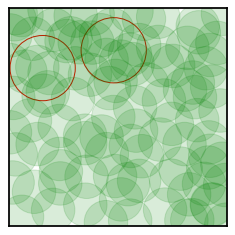

In [14]:
env_num = 2

plot_environment(envs[env_num], fields, sigma)


In [15]:
reload(sc)
g = graphs[env_num][0]
maxsimps = graphs[env_num][1]
binmat = graphs[env_num][2]
pths1 = paths[env_num]
stim = pths1[0, :, :].T

print(nx.info(g))

(embed_pts, dmat, sorted_node_list) = sc.mds_embed(g)
print("preparing data...")
(x, y) = sc.prepare_affine_data(binmat, stim, embed_pts, sorted_node_list)
L = lambda a: sc.affine_loss(a, x, y, 2, 2)


Name: 
Type: Graph
Number of nodes: 1021
Number of edges: 2566
Average degree:   5.0264
preparing data...


Optimization terminated successfully.
         Current function value: 717.899483
         Iterations: 661
         Function evaluations: 1028


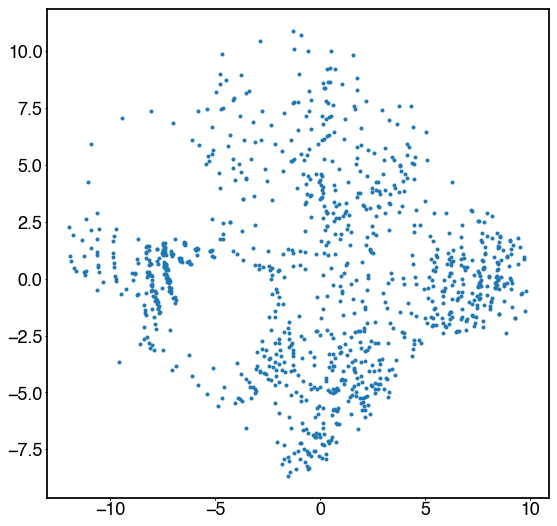

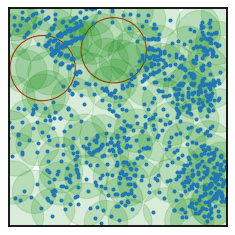

In [16]:
from scipy.optimize import fmin
a_min = fmin(L, [1, 0, 0, 1, 0, 0], maxfun=10000)
# map all the MDS points to original space
A = np.array([[a_min[0], a_min[1]], [a_min[2], a_min[3]]])
b = np.array([a_min[4], a_min[5]])
y_embed = np.dot(A, embed_pts.T) + np.tile(b[:, np.newaxis], (1, np.shape(embed_pts)[0]))

fig0 = plt.figure(figsize=(9,9))
plt.plot(embed_pts[:, 0], embed_pts[:, 1], '.')

fig = plt.figure(figsize=(9,9))
plot_environment(envs[env_num], fields, sigma)
plt.plot(y_embed[0, :], y_embed[1, :], '.')

In [110]:
reload(sc)
A = np.reshape(a_min[0:2*2], (2, 2))
sc.decompose_matrix(A)


(array([[0.05831357, 0.        ],
        [0.        , 0.05831357]]), array([[-0.00061668,  0.00051489],
        [ 0.00051489,  0.00061668]]), array([[ 0.        , -0.11309355],
        [ 0.11309355,  0.        ]]))

In [120]:
g = graphs[env_num][0]
maxsimps = graphs[env_num][1]
binmat = graphs[env_num][2]
pths1 = paths[env_num]
print(nx.info(g))
dg = nx.number_of_nodes(g)
dmat = np.zeros((dg, dg))
sorted_node_list = sorted(list(g.nodes()), key=len)
dmat = nx.floyd_warshall_numpy(g, nodelist=sorted_node_list)

Name: 
Type: Graph
Number of nodes: 1601
Number of edges: 4690
Average degree:   5.8588


In [121]:
from sklearn.manifold import MDS
gmds = MDS(n_jobs=-2, dissimilarity='precomputed')
embed_pts = gmds.fit_transform(dmat)

In [122]:
stims = {}
inds = np.nonzero((np.sum(binmat, axis=0) > 0))[0]
y1 = np.zeros((2, len(inds)))
x1= np.zeros((2, len(inds)))
for ptind, (cg, ind) in enumerate(zip(maxsimps, inds)):
    if cg not in stims.keys():
        stims[cg] = [pths1[0, ind, :]]
    else:
        stims[cg].append(pths1[0, ind, :])
    y1[:, ptind] = pths1[0, ind, :]
    x1[:, ptind] = get_mds_position_of_cg(cg, embed_pts, sorted_node_list)
    
# x = x[:, :5000]
# y = y[:, :5000]
    
def affine_loss(affine, x, y):
    
    a1 = affine[0]
    a2 = affine[1]
    a3 = affine[2]
    a4 = affine[3]
    b1 = affine[4]
    b2 = affine[5]
    A = np.array([[a1, a2], [a3, a4]])
    b = np.array([b1, b2])
    yhat = np.dot(A, x) + np.tile(b[:, np.newaxis], (1, np.shape(x)[1]))
    s = np.power(yhat - y, 2)
    s = np.sum(s, axis=0)
    #s = np.sqrt(s)
    res = np.sum(s)
    return res
    

In [125]:
reload(sc)
print(affine_loss([1,0,0,1,0,0], x1, y1))
sc.affine_loss([1,0,0,1,0,0], x1, y1, 2, 2)


662479.6527888302


662479.6527888302

In [123]:
f = lambda a: affine_loss(a, x1, y1)

from scipy.optimize import fmin
a_min = fmin(f, [1, 0, 0, 1, 0, 0], maxfun=10000)

Optimization terminated successfully.
         Current function value: 2210.852912
         Iterations: 388
         Function evaluations: 609


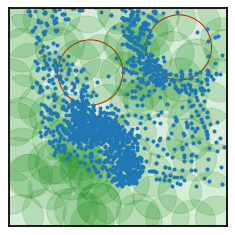

In [124]:
# map all the MDS points to original space
A = np.array([[a_min[0], a_min[1]], [a_min[2], a_min[3]]])
b = np.array([a_min[4], a_min[5]])
y_embed = np.dot(A, embed_pts.T) + np.tile(b[:, np.newaxis], (1, np.shape(embed_pts)[0]))
fig = plt.figure(figsize=(9,9))
plot_environment(envs[env_num], fields, sigma)
plt.plot(y_embed[0, :], y_embed[1, :], '.')

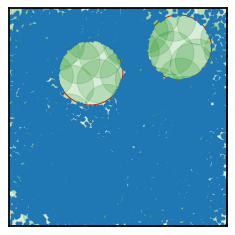

In [57]:
plot_environment(envs[env_num], fields, sigma)
plt.plot(y[0, :], y[1, :], '.')

(-3, 3)

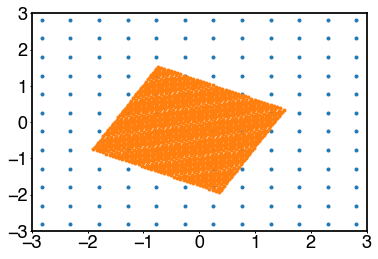

In [109]:
grid = np.array([[x, y] for x in np.linspace(-10, 10, 40) for y in np.linspace(-10, 10, 40)])
plt.plot(grid[:, 0], grid[:, 1], '.')
gridx = sc.affine_transform(a_min, grid.T, 2, 2)
plt.plot(gridx[0, :], gridx[1, :], '.')
plt.ylim([-3, 3])
plt.xlim([-3, 3])

In [102]:
g = graphs[-1]
print(nx.info(g))
dg = nx.number_of_nodes(g)
dmat = np.zeros((dg, dg))
anchored_nodes = [x for x in g.nodes(data='stimulus', default=1) if x[1] is not 1]
print(len(anchored_nodes))
# compute MDS on anchored nodes


sorted_node_list = sorted(list(g.nodes()), key=len)

Name: 
Type: Graph
Number of nodes: 1816
Number of edges: 5503
Average degree:   6.0606
0


In [15]:
def get_mds_position_of_cg(cg, mds_points, sorted_node_list):
    return mds_points[sorted_node_list.index(cg), :]


In [104]:
dmat = nx.floyd_warshall_numpy(g, nodelist=sorted_node_list)

In [103]:
nx.is_connected(g)

True

In [105]:
from sklearn.manifold import MDS
gmds = MDS(n_jobs=-2, dissimilarity='precomputed')
embed_pts = gmds.fit_transform(dmat)

In [44]:
anchored_nodes_dict = nx.get_node_attributes(g, 'stimulus')
y_real = np.zeros((len(sorted_node_list), 2))
# build y_real matrix
for ind, an in enumerate(sorted_node_list):
    if an in anchored_nodes_dict.keys():
        pt = anchored_nodes_dict[an]
        y_real[ind, :] = pt
y_real

array([[-0.95629076,  0.46310891],
       [-0.85867483,  0.2885491 ],
       [-0.81808525,  0.09271119],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.63154913, -0.16771053]])

In [47]:
sorted_node_list = sorted(list(g.nodes()), key=len)


dmat = nx.floyd_warshall_numpy(g, nodelist=sorted_node_list)
# for ind1, n1 in enumerate(nx.nodes(g)):
#     for ind2, n2 in enumerate(nx.nodes(g)):
#         dmat[ind1, ind2] = nx.shortest_path_length(g, source=(1,7,12), target=(14, 18, 22), weight='weight')

In [28]:
from sklearn.manifold import MDS

In [48]:
gmds = MDS(n_jobs=-2, dissimilarity='precomputed')
embed_pts = gmds.fit_transform(dmat)

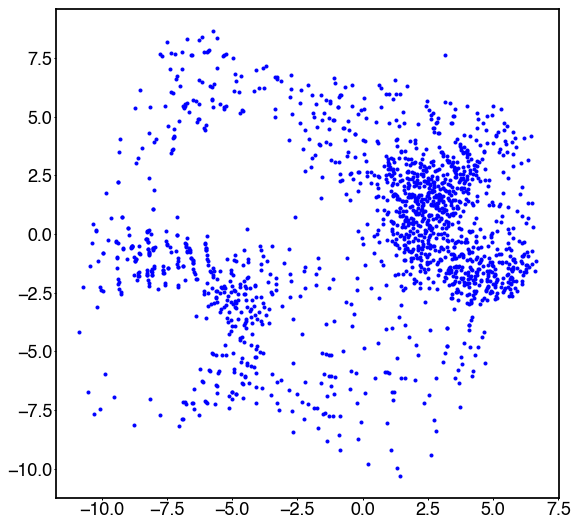

In [19]:
fig = plt.figure(figsize=(9,9))
plt.plot(embed_pts[:, 0], embed_pts[:, 1], 'b.')

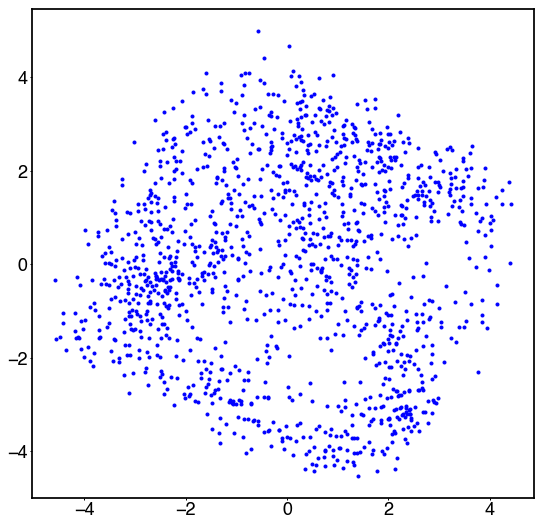

In [95]:
fig = plt.figure(figsize=(9,9))
plt.plot(embed_pts[:, 0], embed_pts[:, 1], 'b.')

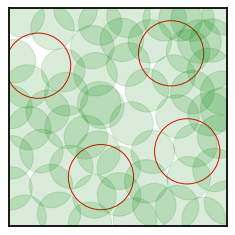

In [40]:
plot_environment(envs[-1], fields, sigma)

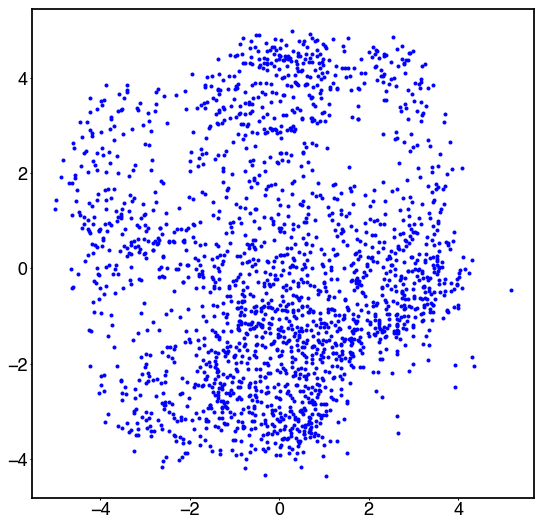

In [39]:
fig = plt.figure(figsize=(9,9))
plt.plot(embed_pts[:, 0], embed_pts[:, 1], 'b.')

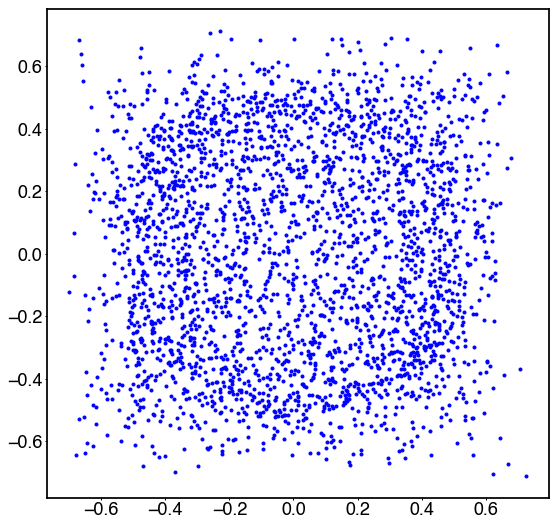

In [31]:
gmds = MDS(n_jobs=-2, dissimilarity='precomputed', metric=False)
embed_pts = gmds.fit_transform(dmat)
fig = plt.figure(figsize=(9,9))
plt.plot(embed_pts[:, 0], embed_pts[:, 1], 'b.')

In [45]:
sorted(list(g.nodes()), key=len)


[(2,),
 (1,),
 (3,),
 (0,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (15,),
 (4,),
 (16,),
 (17,),
 (18,),
 (19,),
 (20,),
 (21,),
 (22,),
 (23,),
 (24,),
 (25,),
 (26,),
 (27,),
 (28,),
 (29,),
 (30,),
 (31,),
 (32,),
 (33,),
 (34,),
 (35,),
 (36,),
 (37,),
 (38,),
 (39,),
 (40,),
 (41,),
 (42,),
 (43,),
 (44,),
 (45,),
 (46,),
 (47,),
 (48,),
 (49,),
 (50,),
 (51,),
 (52,),
 (53,),
 (54,),
 (55,),
 (56,),
 (57,),
 (58,),
 (59,),
 (1, 2),
 (0, 3),
 (2, 3),
 (3, 5),
 (0, 6),
 (1, 6),
 (3, 7),
 (2, 8),
 (8, 9),
 (0, 10),
 (6, 10),
 (0, 11),
 (2, 11),
 (3, 11),
 (7, 11),
 (8, 11),
 (1, 12),
 (6, 12),
 (10, 12),
 (0, 13),
 (7, 13),
 (10, 13),
 (0, 14),
 (1, 14),
 (2, 14),
 (3, 14),
 (6, 14),
 (11, 14),
 (8, 14),
 (12, 14),
 (3, 15),
 (4, 15),
 (7, 15),
 (11, 15),
 (2, 16),
 (3, 16),
 (5, 16),
 (8, 16),
 (3, 8),
 (11, 16),
 (2, 17),
 (8, 17),
 (1, 18),
 (2, 18),
 (6, 18),
 (12, 18),
 (14, 18),
 (17, 18),
 (1, 19),
 (2, 19),
 (12, 19),
 (14, 19),
 (17, 19)

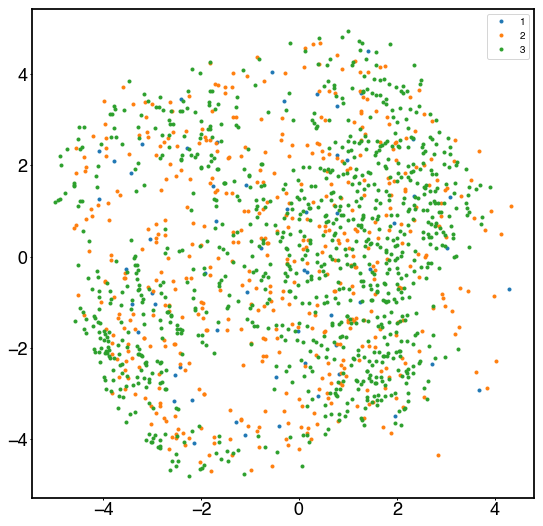

In [57]:
fig = plt.figure(figsize=(9,9))
orders = np.array([len(x) for x in sorted_node_list])
max_ord = 3
for order in range(max_ord):
    inds = (orders == order+1)
    
    plt.plot(embed_pts[inds, 0], embed_pts[inds, 1], '.', label=order+1)
    
plt.legend()

In [51]:
inds

False